In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [5]:
Image_size=256
Batch_size=32
Channels=3
Epochs=20

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/Chessman-image-dataset",  # Use raw string (r"")
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)


Found 552 files belonging to 1 classes.


In [7]:
class_names= dataset.class_names
class_names

['Chess']

In [8]:
len(dataset)

18

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])
    print("label",label_batch[0])

tf.Tensor(
[[[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 [[254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [254. 254. 254.]
  [254. 254. 254.]]

 ...

 [[251. 251. 251.]
  [251. 251. 251.]
  [251. 251. 251.]
  ...
  [250. 250. 250.]
  [250. 250. 250.]
  [250. 250. 250.]]

 [[251. 251. 251.]
  [251. 251. 251.]
  [251. 251. 251.]
  ...
  [250. 250. 250.]
  [250. 250. 250.]
  [250. 250. 250.]]

 [[251. 251. 251.]
  [251. 251. 251.]
  [251. 251. 251.]
  ...
  [250. 250. 250.]
  [250. 250. 250.]
  [250. 250. 250.]]], shape=(256, 256, 3), dtype=float32)
label tf.Tensor(0, shape=(), dtype=int32)


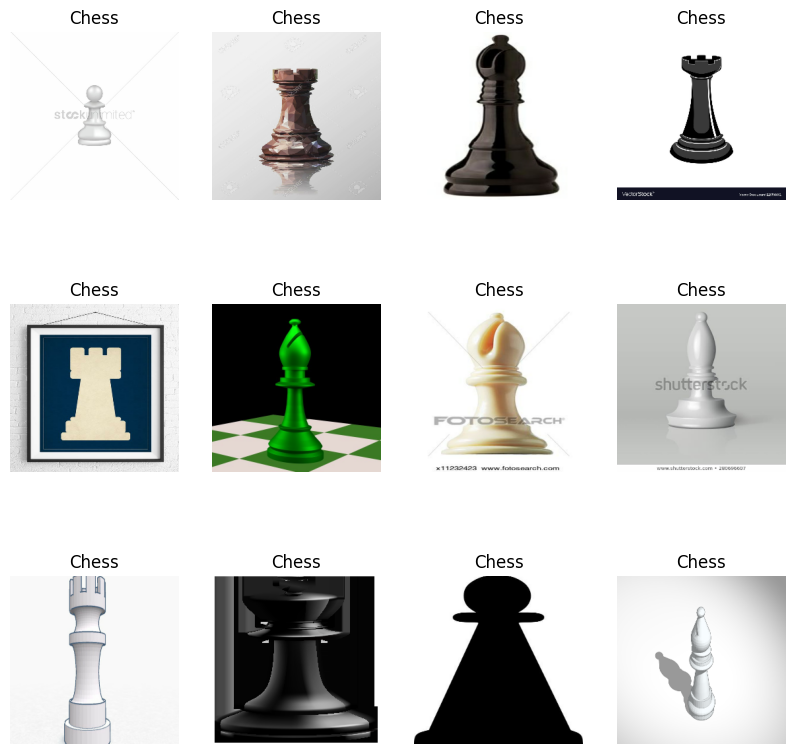

In [11]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
image_count=len(dataset)
image_count

18

In [13]:
train_size=int(image_count*0.8)
train_ds=dataset.take(train_size)
test_ds=dataset.skip(train_size)

In [14]:
print(len(train_ds))
print(len(test_ds))

14
4


In [15]:
val_ds=test_ds.take(6)
len(val_ds)

4

In [16]:
test_ds=test_ds.skip(6)
len(test_ds)

0

In [17]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

14

In [20]:
len(test_ds)

3

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(Image_size, Image_size),
    tf.keras.layers.Rescaling(1.0/255)
])


In [23]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [24]:
for image, label in train_ds.take(1):
    print(image.shape)

(32, 256, 256, 3)


In [25]:
input_shape=(Batch_size,Image_size,Image_size,Channels)
n_classes=2

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(n_classes,activation="sigmoid"),

])
model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 32)               │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 2)                │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,002 (796.88 KB)

 Trainable params: 204,002 (796.88 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True
)


In [30]:
history=model.fit(
    train_ds,
    epochs=50,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 

In [31]:
scores=model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00


In [32]:
scores

[0.0, 1.0]

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 14}

In [35]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [36]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

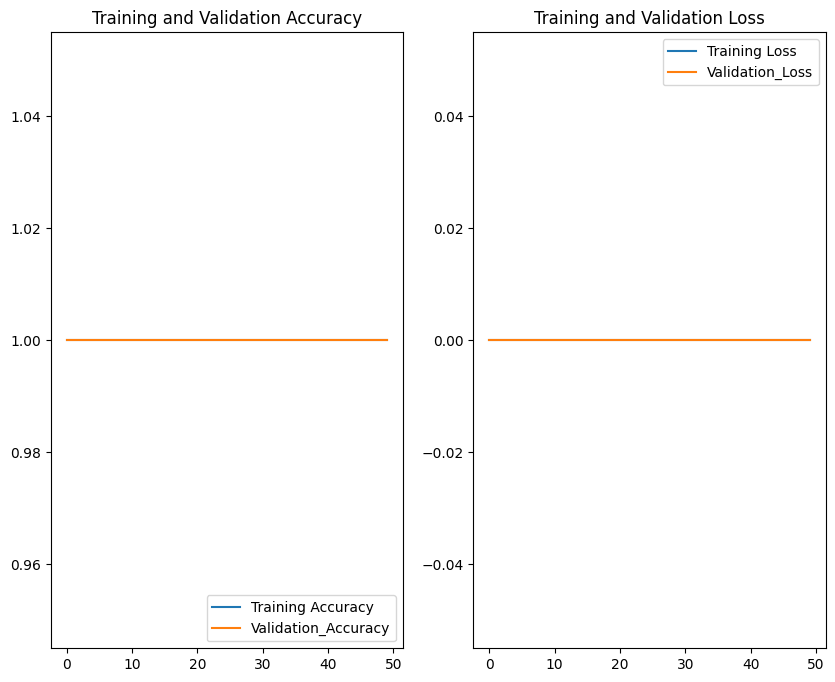

In [37]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
# Use len(acc) instead of Epochs to ensure x and y have the same length
plt.plot(range(len(acc)),acc,label='Training Accuracy')
plt.plot(range(len(val_acc)),val_acc,label="Validation_Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.subplot(1,2,2)
# Use len(loss) instead of Epochs to ensure x and y have the same length
plt.plot(range(len(loss)),loss,label='Training Loss')
plt.plot(range(len(val_loss)),val_loss,label="Validation_Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

[[[ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]
  ...
  [ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]]

 [[ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]
  ...
  [ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]]

 [[ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]
  ...
  [ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]]

 ...

 [[ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]
  ...
  [ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]]

 [[ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]
  ...
  [ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]]

 [[ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]
  ...
  [ 76 105 113]
  [ 76 105 113]
  [ 76 105 113]]]


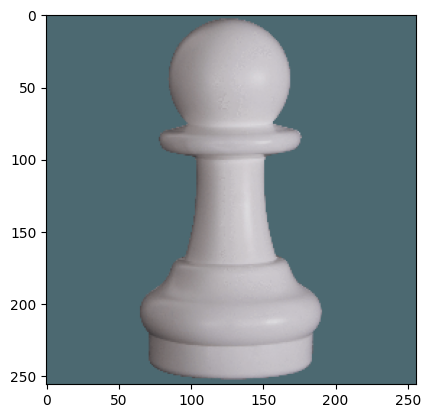

In [38]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch[0].numpy().astype('uint8'))
    plt.imshow(images_batch[0].numpy().astype('uint8'))

First Image to predict
actual label: Chess
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: Chess


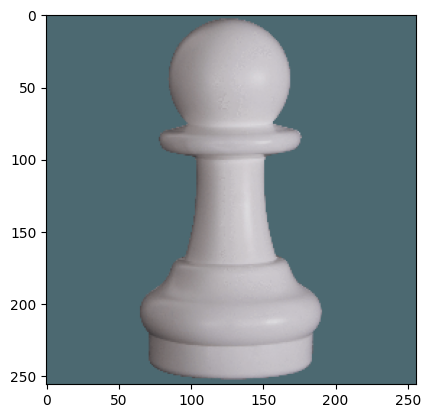

In [39]:
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])


In [40]:
def predict(model,img):
    img_array =tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array =tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


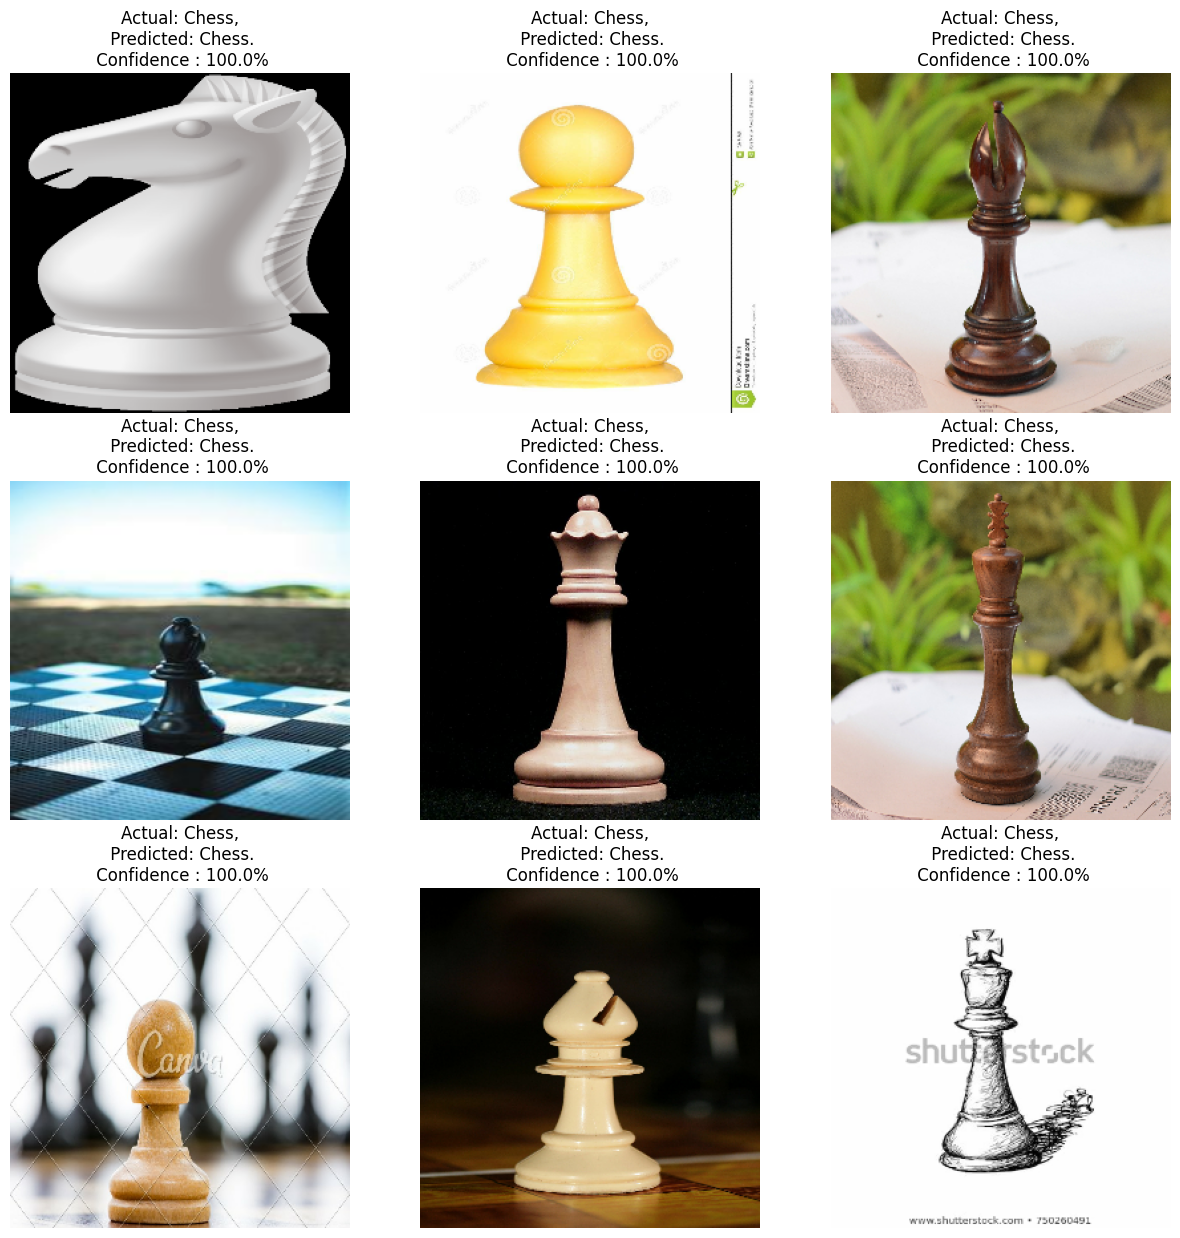

In [41]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class= class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence : {confidence}%")
        plt.axis("off")

In [42]:
# Extract true labels from tf.data.Dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Convert from one-hot encoding if needed
if len(y_true.shape) > 1 and y_true.shape[-1] > 1:
    y_true = np.argmax(y_true, axis=-1)  # Convert one-hot to class labels

# Ensure y_true is an array
y_true = np.array(y_true)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


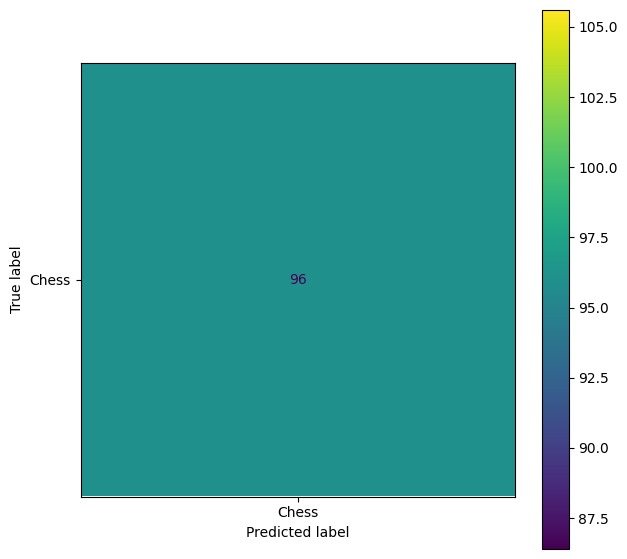

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7, 7))  # Set the figure size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')
    plt.show()

# Extract true labels and predicted labels
y_true = []
y_pred = []

# Assuming test_ds is your test dataset
for images, labels in test_ds:
    predictions = model.predict(images)  # Get predictions for the batch
    y_true.extend(labels.numpy())       # Add true labels to the list
    y_pred.extend(np.argmax(predictions, axis=1))  # Add predicted labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)  # Calculate confusion matrix

# Now call the function to plot the matrix
plot_confusion_matrix(conf_mat, class_names)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Confusion Matrix:
[[96]]


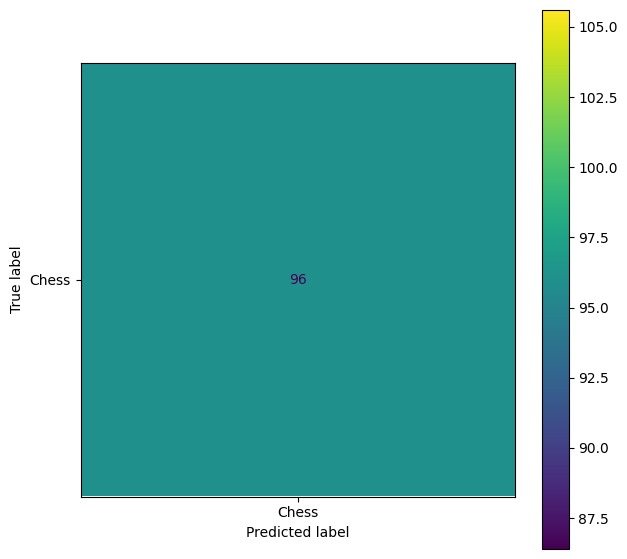

In [44]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)  # Use y_pred instead of y_pred_classes

print("Confusion Matrix:")
print(conf_mat)

# Plot confusion matrix
plot_confusion_matrix(conf_mat, class_names)

In [45]:
pip install kolmogorov-arnold-network


ERROR: Could not find a version that satisfies the requirement kolmogorov-arnold-network (from versions: none)
ERROR: No matching distribution found for kolmogorov-arnold-network


In [46]:
import tensorflow as tf
from tensorflow.keras import layers

class KANLayer(layers.Layer):
    def __init__(self, units=64, activation="relu"):
        super(KANLayer, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Define learnable coefficients for a polynomial function (KAN uses function approximation)
        self.coefficients = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        # Apply a polynomial transformation (simplified KAN approach)
        x = tf.matmul(inputs, self.coefficients) + self.bias
        return self.activation(x)


In [47]:
input_shape = (Batch_size, Image_size, Image_size, Channels)
n_classes = 3

model2 = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,

    # KAN Layers replacing Conv2D layers
    KANLayer(units=64, activation='relu'),  # Learnable transformation
    KANLayer(units=64, activation='relu'),
    KANLayer(units=64, activation='relu'),
    KANLayer(units=64, activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])


In [48]:
# Build & Compile the model
model2.build(input_shape=input_shape)
model2.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [49]:
# Train the model
Epochs=20
history = model2.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 213s 15s/step - accuracy: 0.7696 - loss: 0.2543 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 206s 15s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 257s 14s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 206s 15s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 204s 15s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 204s 15s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [50]:
scores=model2.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00


In [51]:
scores

[0.0, 1.0]

In [52]:
history

In [53]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 14}

In [54]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [55]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [56]:
print(len(acc), len(val_acc))  # Should match Epochs
print(len(loss), len(val_loss))  # Should match Epochs


6 6
6 6


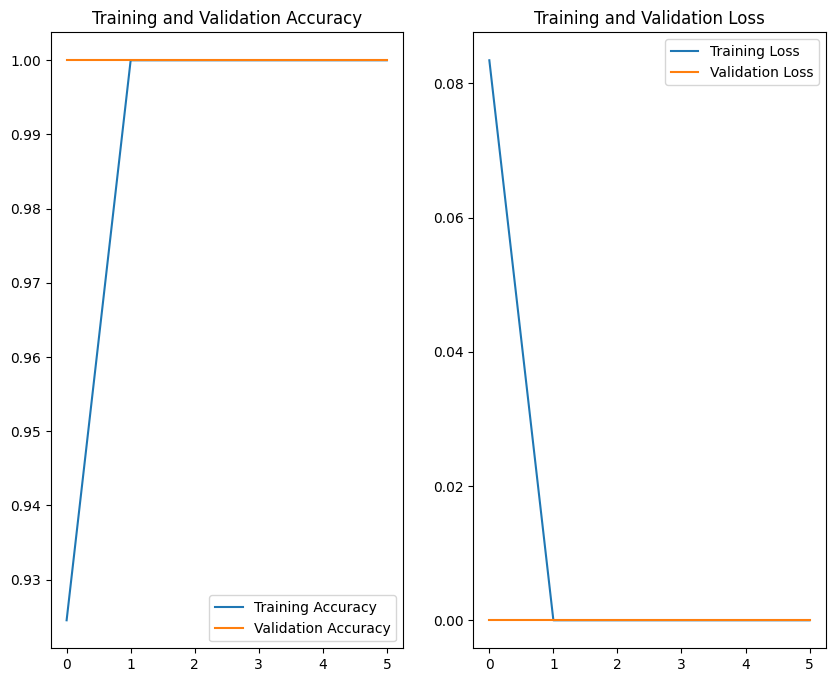

In [57]:
plt.figure(figsize=(10, 8))

# Adjust x-axis range to match the actual training epochs
epochs_range = range(len(acc))  # Instead of range(Epochs)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

plt.show()


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


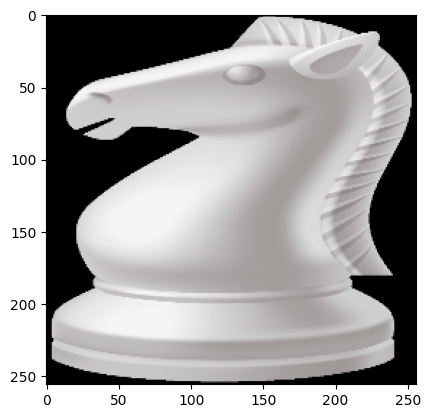

In [58]:
for image_batch,label_batch in test_ds.take(1):
    print(image_batch[0].numpy().astype("uint8"))
    plt.imshow(image_batch[0].numpy().astype('uint8'))


First Image to predict
actual label: Chess
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction label: Chess


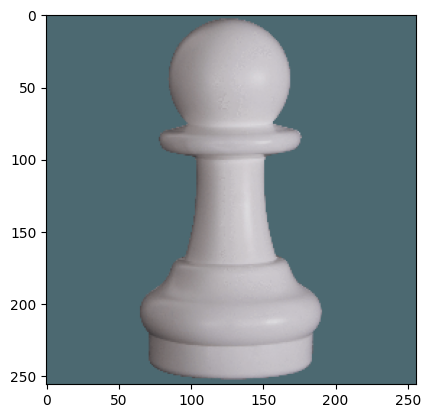

In [59]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction=model2.predict(image_batch)
    print("Prediction label:",class_names[np.argmax(batch_prediction[0])])

In [60]:
def predict(model2,img):
    img_array =tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array =tf.expand_dims(img_array,0)

    predictions=model2.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


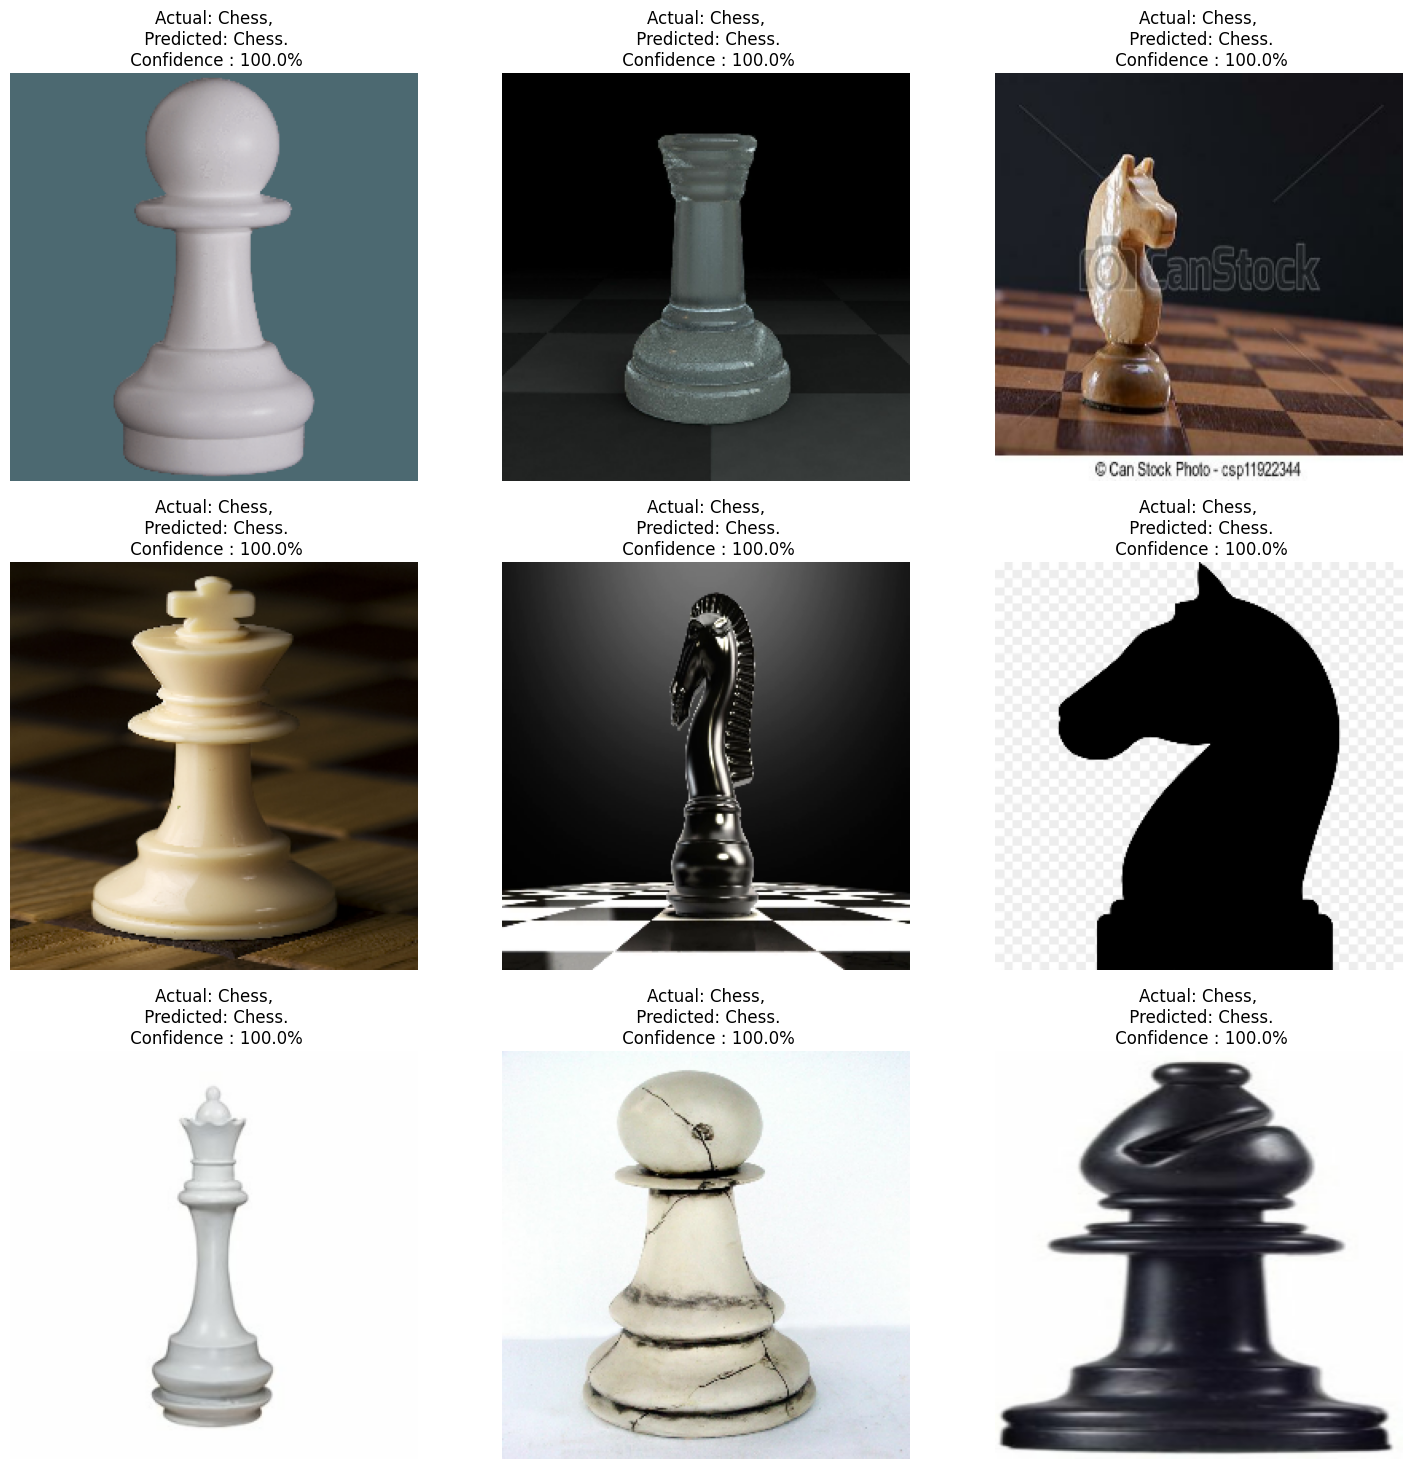

In [61]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence=predict(model2,images[i].numpy())
        actual_class= class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence : {confidence}%")
        plt.axis("off")

In [62]:
model_version_potatos= 1
model2.save(fr"D:\vishnu\Potato Disease Classification\Saved_models{model_version_potatos}.h5")


In [63]:
# Extract true labels from tf.data.Dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Convert from one-hot encoding if needed
if len(y_true.shape) > 1 and y_true.shape[-1] > 1:
    y_true = np.argmax(y_true, axis=-1)  # Convert one-hot to class labels

# Ensure y_true is an array
y_true = np.array(y_true)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


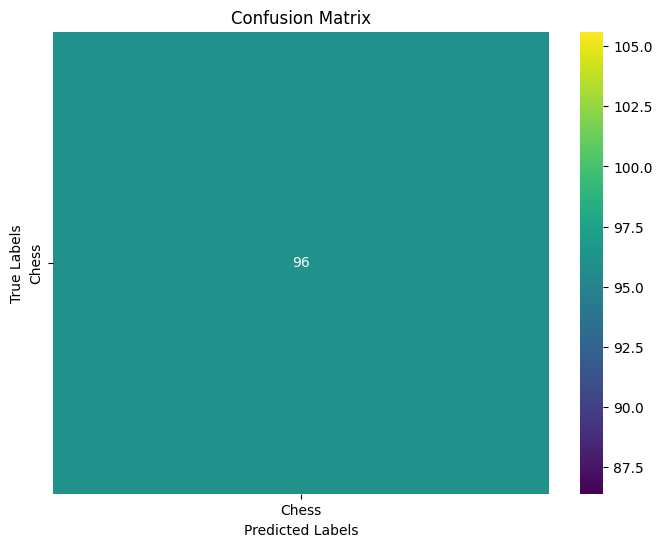

In [64]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to make predictions
def predict(model2, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to match model input

    predictions = model2.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Store true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    for i in range(len(images)):
        true_label = class_names[labels[i].numpy()]  # Get actual class name
        predicted_label, _ = predict(model2, images[i])  # Get predicted class

        y_true.append(true_label)
        y_pred.append(predicted_label)

# Compute Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred, labels=class_names)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


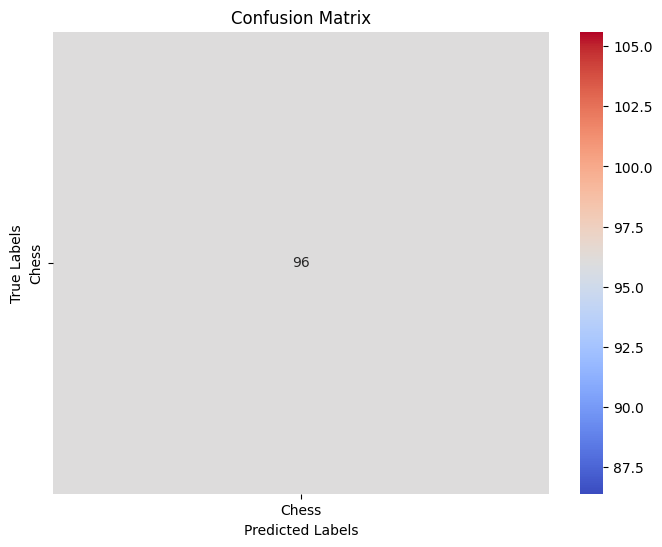

In [65]:

# Compute Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred, labels=class_names)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [66]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

In [67]:
# Define constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 20
DATASET_PATH = "D:/vishnu/Potato Disease Classification/PlantVillage"  # Change this if needed


In [69]:
# Get class names
class_names = dataset.class_names
num_classes = len(class_names)


In [70]:
def process(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

dataset = dataset.map(process)

In [71]:
# Split dataset into training and validation
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


In [72]:
# Load EfficientNetB0 as base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False  # Freeze base model layers


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [73]:

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output)


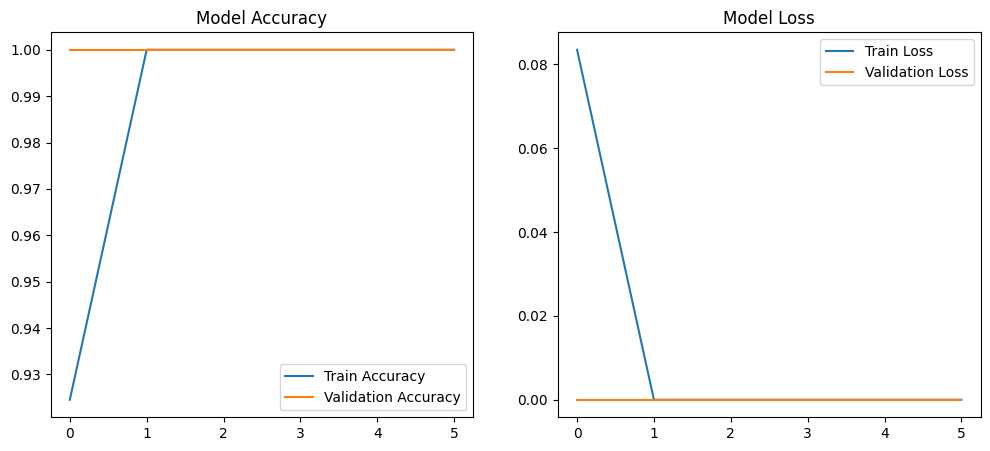

In [75]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


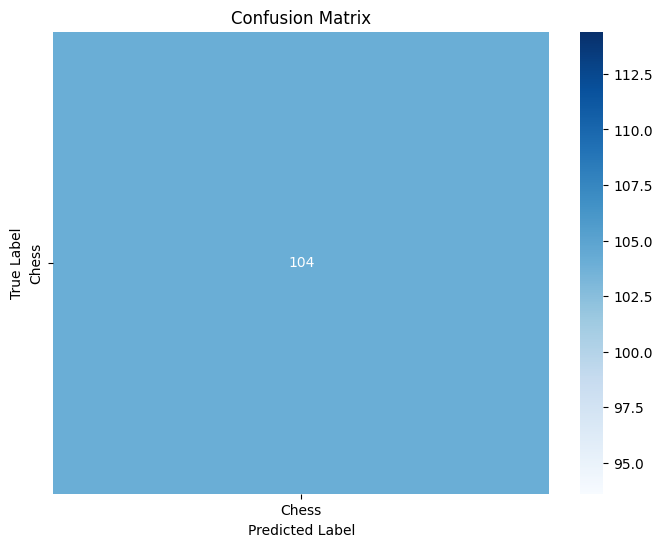

              precision    recall  f1-score   support

       Chess       1.00      1.00      1.00       104

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



In [77]:
# Generate predictions
y_true = []
y_pred = []
for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))